In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams.update({'figure.figsize':(10,6), 'image.cmap':'RdBu_r',
                     'font.size':14})

/home/jedman/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/jedman/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import datetime

In [3]:
import stravalib

In [5]:
with open('../api_key') as api_file:
    CLIENT_ID = api_file.readline().replace('\n','')
    CLIENT_SECRET = api_file.readline().strip()
    ACCESS_TOKEN = api_file.readline().strip()

In [6]:
# access using stored access token 
# can use id + secret to retrieve token as well using 
# client.exchange_code_for_token
client = stravalib.Client(access_token=ACCESS_TOKEN) 

print(client.get_athlete()) # me 

print(client.get_athlete(athlete_id=7656735))#stephanie

<Athlete id=1639875 firstname=b'Jake' lastname=b'Edman'>
<Athlete id=7656735 firstname=b'Stephanie' lastname=b'Wuerth'>


In [7]:
# get segment ids from most recent runs
segment_ids = []
for a in client.get_activities( limit = 5 ):
    # this is jank but I can't pass include_all_efforts to get_activities
    activity = client.get_activity(a.id, include_all_efforts = True) # return all segment efforts
    for effort in activity.segment_efforts:
        segment_ids.append(effort.segment.id)

In [8]:
print('number of segment efforts: {}'.format( len(segment_ids)))
segment_ids_unique = list(set(segment_ids))
print('number of unique segments: {}'.format( len(segment_ids_unique)))
# could choose to weight by frequency of segments, or not 

number of segment efforts: 61
number of unique segments: 57


In [34]:
# fixed stravalib so it takes context_entries now
# can return the whole leaderboard by requesting top_results_limit = 0, but that seems bad
#test = client.get_segment_leaderboard(segment_id = segment_ids[1], top_results_limit=1, context_entries=5)
# still can't get it to print less than 1 of the top entries though-- will have to strip that off 

In [15]:
## get a dictionary with segment_id as key, with all the nearby athletes in a dict 
segment_rivals = dict()
counter = 0
total = len(segment_ids_unique)
athlete_names = dict() # master table

for segment_id in segment_ids_unique:
    counter = counter + 1
    try:
        leaderboard = client.get_segment_leaderboard(segment_id = segment_id,
                                                     top_results_limit=1, context_entries=10)
        print('on segment {}, {} of {}'.format(segment_id, counter, total ))
    except:
        # janky error handling, should specify http error -- probably need urllib2
        print('whoops, error on {}, {} of {}'.format(segment_id, counter, total ))
    
    segment_athletes = dict()
    for i, entry in enumerate(leaderboard):
        # remove first entry 
        # should only do this if athlete isn't in top ranking
        if i == 0:
            continue
        else:
            segment_athletes[entry.athlete_id] = entry.athlete_name
            athlete_names[entry.athlete_id] = entry.athlete_name
    
    segment_rivals[segment_id] = segment_athletes
    
            
        
        
    

on segment 6390656, 1 of 57
on segment 10239747, 2 of 57
on segment 2548356, 3 of 57
on segment 2773381, 4 of 57
on segment 1679751, 5 of 57
on segment 780296, 6 of 57
on segment 11450121, 7 of 57
on segment 780298, 8 of 57
on segment 775819, 9 of 57
on segment 1710600, 10 of 57
on segment 6221970, 11 of 57
on segment 1086483, 12 of 57
on segment 2188818, 13 of 57
on segment 6634646, 14 of 57
on segment 786327, 15 of 57
on segment 9274904, 16 of 57
on segment 775961, 17 of 57
on segment 9174172, 18 of 57
on segment 5337633, 19 of 57
on segment 12544551, 20 of 57
on segment 1268136, 21 of 57
on segment 4564009, 22 of 57
on segment 2459184, 23 of 57
on segment 1733555, 24 of 57
on segment 7220787, 25 of 57
on segment 12544566, 26 of 57
on segment 11827516, 27 of 57
on segment 1065663, 28 of 57
on segment 1921855, 29 of 57
on segment 9435457, 30 of 57
on segment 1012803, 31 of 57
on segment 7566404, 32 of 57
on segment 692805, 33 of 57
on segment 8266951, 34 of 57
on segment 813005, 35 of

In [16]:
segment_rivals

{692805: {11446: 'Jim (James)  Wingert ',
  117763: 'Kevin Coady (TriForce!)',
  180613: 'Jason Eshleman',
  263323: 'David Weisz',
  313948: 'Travis Gaylord',
  406973: 'Andrew Sellergren',
  528022: 'John Nickerson',
  978647: 'Billy Janhunen',
  1152767: 'Alexander Teran',
  1639875: 'Jake Edman',
  1677002: 'Nick Lucey',
  1735545: 'Jack LaBarba',
  1788212: 'Darrin Banks',
  1940997: 'Fergal C',
  2244222: 'David Craig',
  2527706: 'Kyle Ormsby',
  2694100: 'Richard Ollington',
  3419660: 'nicholas raber',
  6451258: 'Brandon Brown',
  6727610: 'David Siegel',
  8439942: 'Reece Clark'},
 710891: {163986: 'Kim Christensen',
  263777: 'Michael Lepie',
  282172: 'Dennis Roth',
  595867: 'Matthew Penfold',
  684498: 'Dan Tsai',
  794543: 'Dan B',
  823991: 'Sidney Buchbinder',
  1291908: 'Steve Yamamoto',
  1319158: 'Alden Woodrow',
  1639875: 'Jake Edman',
  2086367: 'christopher  mishima',
  2580864: 'Hannah Miller',
  2852559: 'Danny Seigle',
  3501061: 'Nate Wilairat',
  3871821: 

In [17]:
# make a frame with all of the rivals
df = pd.DataFrame.from_dict(segment_rivals, orient = 'index')
athlete_counts = df.count().to_frame('counts')


In [18]:
# make a frame with the names and ids
names = pd.Series(athlete_names).to_frame('athlete_name')
names.rename(index = {0:'athlete_id'}, inplace=True)

In [19]:
# join the frames
rival_counts = pd.merge(athlete_counts, names, how = 'inner', left_index = True, right_index = True)
rival_counts.index.name = 'athlete_id'

In [20]:
# here's the result! luckily i'm my own most common competitor
rival_counts.sort_values('counts', ascending=False)

,counts,athlete_name
athlete_id,,
1639875,57,Jake Edman
405375,10,Doug LeMoine
7656735,10,Stephanie Wuerth
4406515,9,Stephen Granger-Bevan
2028620,9,Aaron Steele
117763,9,Kevin Coady (TriForce!)
3379,8,Erik Wilde
2601909,8,Torsten Heinemann
902913,8,Patrick Madigan


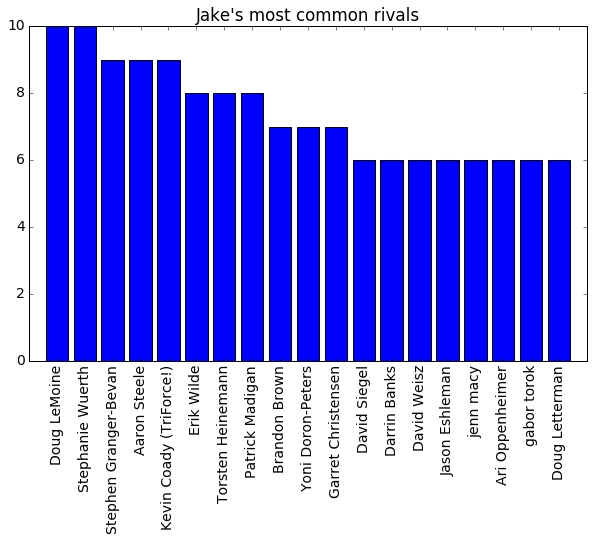

In [54]:
sorted_counts = rival_counts.sort_values('counts', ascending=False)
plt.bar( np.arange(1,20), sorted_counts.counts[1:20], align = 'center')
plt.xticks(np.arange(1,20), sorted_counts.athlete_name[1:20] , rotation = 90)
plt.title("Jake's most common rivals")